<a href="https://colab.research.google.com/github/smf-9000/Text-Intent-Classification/blob/main/Text_Classification_LSTM_glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00570/clinc150_uci.zip

--2021-07-10 17:01:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00570/clinc150_uci.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1053960 (1.0M) [application/x-httpd-php]
Saving to: ‘clinc150_uci.zip’

clinc150_uci.zip    100%[===================>]   1.00M  --.-KB/s    in 0.06s   

2021-07-10 17:01:53 (17.7 MB/s) - ‘clinc150_uci.zip’ saved [1053960/1053960]



In [ ]:
!unzip /content/clinc150_uci.zip -d /content

Archive:  /content/clinc150_uci.zip
   creating: /content/clinc150_uci/
  inflating: /content/clinc150_uci/data_small.json  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/clinc150_uci/
  inflating: /content/__MACOSX/clinc150_uci/._data_small.json  
  inflating: /content/clinc150_uci/meta.txt  
  inflating: /content/__MACOSX/clinc150_uci/._meta.txt  
  inflating: /content/clinc150_uci/LICENSE  
  inflating: /content/clinc150_uci/data_oos_plus.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_oos_plus.json  
  inflating: /content/clinc150_uci/data_imbalanced.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_imbalanced.json  
  inflating: /content/clinc150_uci/data_full.json  
  inflating: /content/__MACOSX/clinc150_uci/._data_full.json  


In [ ]:
import pandas as pd
import json

In [ ]:
with open('/content/clinc150_uci/data_full.json', 'r') as file:
  data_JSON = file.read()
  data = json.loads(data_JSON)
  
sentences = []
labels = []
CL = {}
for tajp in ['train', 'test', 'val']:
  for s, c in data[tajp]:
    if c not in CL:
      CL[c] = len(CL.keys())
    sentences.append(s)
    labels.append(CL[c])

In [ ]:
list(zip(sentences, labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence

In [ ]:
vocab_size = 10000

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

vocab_size = 10000
max_length = 100

X_train, X_test, Y_train, Y_test = train_test_split(sentences, labels, test_size=0.2, random_state=1)

tokenizer = text.Tokenizer(vocab_size)
tokenizer.fit_on_texts(np.concatenate([X_train, X_test]))

train_tokenized = tokenizer.texts_to_sequences(X_train) 
train_inputs = sequence.pad_sequences(train_tokenized, maxlen=max_length)

test_tokenized = tokenizer.texts_to_sequences(X_test) 
test_inputs = sequence.pad_sequences(test_tokenized, maxlen=max_length)

training_labels_final = np.array(Y_train)
testing_labels_final = np.array(Y_test)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-07-10 17:01:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-10 17:01:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-10 17:01:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
glove_dim = 200
glove_file = '/content/glove.6B.' + str(glove_dim) + 'd.txt'
emb_dict = {}
glove = open(glove_file)
for line in glove:
  values = line.split()
  word = values[0]
  vector = np.asarray(values[1:], dtype='float32')
  emb_dict[word] = vector
glove.close()

In [ ]:
emb_matrix = np.zeros((vocab_size, glove_dim))
for w, i in tokenizer.word_index.items():
  if i < vocab_size:
    vect = emb_dict.get(w)
    if vect is not None:
      emb_matrix[i] = vect
  else:
    break



```
# ----------------------------------------------------------------------
```



In [ ]:
num_epochs = 100

class DCLIN(tf.keras.Model):
    
    def __init__(self):
        super(DCLIN, self).__init__(name='model_i')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        self.pool_1 = layers.GlobalAveragePooling1D()
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.pool_1(x)
        x = self.dense_1(x)
        output = self.dense_last(x)
        return output

model = DCLIN()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(train_inputs, training_labels_final, epochs=num_epochs, validation_data=(test_inputs, testing_labels_final))

Epoch 1/100
563/563 [==============================] - 5s 3ms/step - loss: 4.4939 - sparse_categorical_accuracy: 0.1378 - val_loss: 3.6723 - val_sparse_categorical_accuracy: 0.3064
Epoch 2/100
563/563 [==============================] - 2s 3ms/step - loss: 2.9348 - sparse_categorical_accuracy: 0.4441 - val_loss: 2.3541 - val_sparse_categorical_accuracy: 0.5538
Epoch 3/100
563/563 [==============================] - 2s 3ms/step - loss: 1.9583 - sparse_categorical_accuracy: 0.6247 - val_loss: 1.6952 - val_sparse_categorical_accuracy: 0.6516
Epoch 4/100
563/563 [==============================] - 2s 3ms/step - loss: 1.4421 - sparse_categorical_accuracy: 0.7134 - val_loss: 1.3172 - val_sparse_categorical_accuracy: 0.7289
Epoch 5/100
563/563 [==============================] - 2s 3ms/step - loss: 1.1379 - sparse_categorical_accuracy: 0.7703 - val_loss: 1.0777 - val_sparse_categorical_accuracy: 0.7696
Epoch 6/100
563/563 [==============================] - 2s 3ms/step - loss: 0.9423 - sparse_cate

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

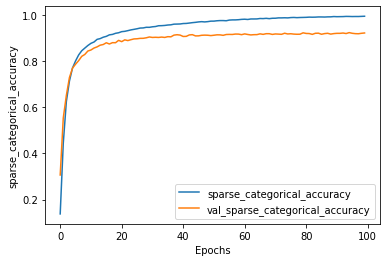

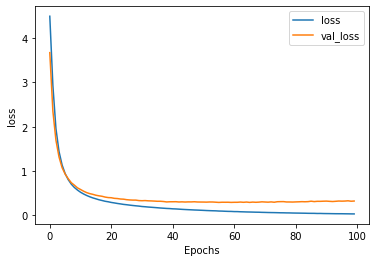

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [ ]:
# some stuff from Keras github
# def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
#   # Keep the original sentences so that we can keep using them later
#   # Create an array to hold the encoded sequences
#   new_sequences = []

#   # Convert the new reviews to sequences
#   for i, frvw in enumerate(new_sentences):
#     new_sequences.append(tokenizer.encode(frvw))

#   # Pad all sequences for the new reviews
#   new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
#                                  padding='post', truncating='post')             

#   classes = model.predict(new_reviews_padded)

#   # The closer the class is to 1, the more positive the review is
#   for x in range(len(new_sentences)):
    
#     # We can see the padded sequence if desired
#     # Print the sequence
#     if (show_padded_sequence):
#       print(new_reviews_padded[x])
#     # Print the review as text
#     print(new_sentences[x])
#     # Print its predicted class
#     print(classes[x])
#     print("\n")



```
# ----------------------------------------------------------------------
```



In [ ]:
class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_ii')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256))
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(train_inputs, training_labels_final, epochs=num_epochs, validation_data=(test_inputs, testing_labels_final))

Epoch 1/100
563/563 [==============================] - 16s 17ms/step - loss: 2.0131 - sparse_categorical_accuracy: 0.5253 - val_loss: 0.6591 - val_sparse_categorical_accuracy: 0.8187
Epoch 2/100
563/563 [==============================] - 9s 16ms/step - loss: 0.5643 - sparse_categorical_accuracy: 0.8407 - val_loss: 0.4119 - val_sparse_categorical_accuracy: 0.8798
Epoch 3/100
563/563 [==============================] - 9s 16ms/step - loss: 0.3519 - sparse_categorical_accuracy: 0.8969 - val_loss: 0.3387 - val_sparse_categorical_accuracy: 0.9029
Epoch 4/100
563/563 [==============================] - 9s 16ms/step - loss: 0.2540 - sparse_categorical_accuracy: 0.9258 - val_loss: 0.2947 - val_sparse_categorical_accuracy: 0.9189
Epoch 5/100
563/563 [==============================] - 9s 16ms/step - loss: 0.1896 - sparse_categorical_accuracy: 0.9425 - val_loss: 0.2976 - val_sparse_categorical_accuracy: 0.9187
Epoch 6/100
563/563 [==============================] - 9s 16ms/step - loss: 0.1535 - spar

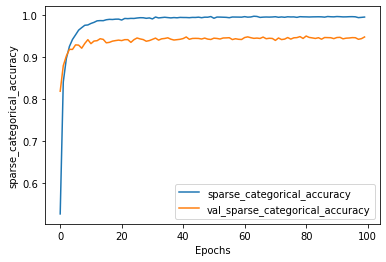

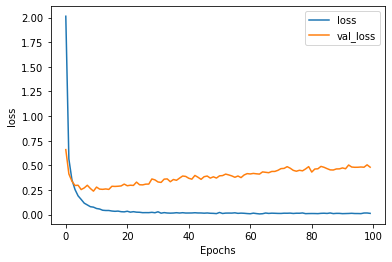

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")



```
# ----------------------------------------------------------------------
```



In [ ]:
class DCLSTM(tf.keras.Model):
    
    def __init__(self):
        super(DCLSTM, self).__init__(name='model_iii')
        
        # self.embedding = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
        self.embedding = layers.Embedding(
                            vocab_size,
                            glove_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(emb_matrix),
                            trainable=False)
        # self.pool_1 = layers.GlobalAveragePooling1D()
        self.lstm_1 = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.2))
        self.lstm_2 = layers.Bidirectional(layers.LSTM(256, dropout=0.2))
        self.rv_1 = layers.RepeatVector(3)
        self.dense_1 = layers.Dense(
                            units=256,
                            activation="relu")
        self.dense_last = layers.Dense(
                            units=150,
                            activation="sigmoid")
        self.dropout_e = layers.Dropout(rate=0.2)
        self.dropout_d = layers.Dropout(rate=0.2)

    
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.dropout_e(x)
        # x = self.pool_1(x)
        x = self.lstm_1(x)
        x = self.lstm_2(x)
        x = self.dense_1(x)
        x = self.dropout_d(x)
        output = self.dense_last(x)
        return output

model = DCLSTM()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['sparse_categorical_accuracy'])
history = model.fit(train_inputs, training_labels_final, epochs=num_epochs, validation_data=(test_inputs, testing_labels_final))

Epoch 1/100
563/563 [==============================] - 26s 39ms/step - loss: 2.2806 - sparse_categorical_accuracy: 0.4339 - val_loss: 0.7748 - val_sparse_categorical_accuracy: 0.7678
Epoch 2/100
563/563 [==============================] - 21s 37ms/step - loss: 0.7404 - sparse_categorical_accuracy: 0.7833 - val_loss: 0.4794 - val_sparse_categorical_accuracy: 0.8542
Epoch 3/100
563/563 [==============================] - 21s 37ms/step - loss: 0.4843 - sparse_categorical_accuracy: 0.8567 - val_loss: 0.3838 - val_sparse_categorical_accuracy: 0.8878
Epoch 4/100
563/563 [==============================] - 21s 37ms/step - loss: 0.3510 - sparse_categorical_accuracy: 0.8918 - val_loss: 0.3419 - val_sparse_categorical_accuracy: 0.9004
Epoch 5/100
563/563 [==============================] - 21s 37ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9153 - val_loss: 0.3249 - val_sparse_categorical_accuracy: 0.9038
Epoch 6/100
563/563 [==============================] - 21s 37ms/step - loss: 0.2281 -

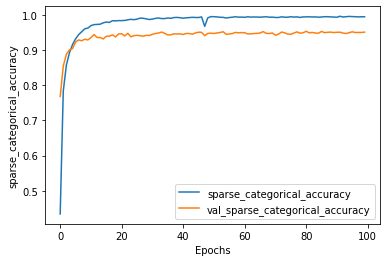

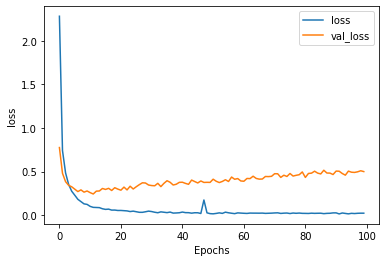

In [ ]:
plot_graphs(history, "sparse_categorical_accuracy")
plot_graphs(history, "loss")